# Figure 5: Gene-level 5hmC analysis

This notebook analyses 5hmC at a gene-level to identify which genes have high levels of 5hmC. To do this, the sample CpG sites are grouped by gene and gene feature. An average ratio of 5hmCpG per CpG (5hmC level) is calculated for each gene and feature, and then a genome-wide average is calculated from that. 

We then calculate an enrichment score for each gene and feature, which is the log2 fold-ratio of the gene/feature's 5hmC level to the genome-wide (genic) average. Sorting by score, we then compare methods using Spearman's rank correlation coefficient. In this case, the null-hypothesis is that the two sets of enrichment scores are unrelated (i.e., that nanopore hydroxymethylation is completely unrelated to TAB hydroxymethylation at the gene level). The alternative hypothesis is that the two sets of scores are related. The higher the Spearman statistic, the more closely related the score sets are. 

Of the genes with the highest 5hmC enrichment score (filtered), we then look at whether 5hmC is accumulated within a particular feature type. The null hypothesis is that 5hmC is randomly scattered across these genes, in which case each feature will have the same mean 5hmC level. The alternative hypothesis is that 5hmC is concentrated in a given feature, in which case a single feature will have a larger 5hmC level or at least more CpG sites that contain some 5hmC. 

In [1]:
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
import pandas as pd

dry = True

if dry == True:
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_stranded_sub.bed'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = pd.read_csv(tab_bed_path, sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth", "strand"])

else:
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_stranded.bed'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = pd.read_csv(tab_bed_path, sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth", "strand"])


In [3]:
import mygene

ens_df = pd.read_csv("./feature_references/genes/GENCODE_Basic_mm39_promotersSubtracted.bed", sep="\t",
                     names=["Chromosome", "Start", "End", "ENSID", "Type"])
ens_df["ENSID"] = ens_df["ENSID"].str.split(".", expand=True)[0]

mg = mygene.MyGeneInfo()
query_df = pd.DataFrame(mg.querymany(ens_df["ENSID"], scopes="ensembl.transcript", fields="symbol"))
output_df = query_df.merge(ens_df.rename(columns={"ENSID" : "query"}), "inner", "query")[["Chromosome", "Start", "End", "symbol", "query"]]

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

In [10]:
import pyranges as pr

output_pr = pr.PyRanges(output_df)
output_merge = output_pr.merge()
output_cluster_df = output_merge.insert(
    output_pr.cluster().apply(f=lambda df: df.groupby(["Cluster"])["symbol"].apply(list), 
                              as_pyranges=False)
                              ).as_df()
output_cluster_df["symbol"] = output_cluster_df["symbol"].apply(lambda S: S.pop(0))

In [87]:
import pyranges as pr
import numpy as np

def addStrandsToTAB(tab_pr):
    stranded_tab_bed = pr.read_bed('./data/TAB_data/CRR008807_TAB_cytosine_report.tsv.CpG_report_strands.zero.bed')
    return tab_pr.join(stranded_tab_bed).drop(["Start_b", "End_b"])

def makePyrange(df):
    if "strand" in df.columns:
        df["Chromosome"], df["Start"], df["End"], df["Strand"] = df["chromosome"], df["chromStart"], df["chromEnd"], df["strand"]
        df = df[["Chromosome", "Start", "End", "Strand", "percentMeth"]]
        return  pr.PyRanges(df)
    else: 
        df["Chromosome"], df["Start"], df["End"] = df["chromosome"], df["chromStart"], df["chromEnd"]
        df = df[["Chromosome", "Start", "End", "percentMeth"]]
        return  addStrandsToTAB(pr.PyRanges(df))
    
def intersectGenes(pyrange):
    gene_bed = pr.read_bed('./feature_references/genes/GENCODE_Basic_mm39.bed')
    return pyrange.join(gene_bed, 
                        strandedness="same", 
                        suffix="_gene").drop(["ItemRGB", "BlockCount", "BlockSizes", "Score", "ThickEnd", "ThickStart", "BlockStarts"])

def groupGenesMakeDF(pyrange):
    genic_means = pyrange.as_df().groupby(["Name"])["percentMeth"].mean().reset_index()
    return genic_means

def log2FromMean(mean_df):
    mean = mean_df["percentMeth"].mean()
    
    with np.errstate(divide="ignore"):
        mean_df["log2FromMean"] = np.log2(
            np.divide(mean_df["percentMeth"], mean)
        )

    return mean_df.replace(-np.inf, np.nan)

def ax1MethodWrapper(df):
    pyrange = makePyrange(df)
    pr_with_genes = intersectGenes(pyrange)
    grouped_by_gene = groupGenesMakeDF(pr_with_genes)
    grouped_by_gene = log2FromMean(grouped_by_gene)
    return grouped_by_gene

def ax1Main():
    grouped_nano_df = ax1MethodWrapper(nano_hmc_df)
    grouped_tab_df = ax1MethodWrapper(tab_df)
    merged_df = pd.merge(grouped_nano_df, grouped_tab_df, "inner", ["Name"], suffixes=["_Nanopore", "_TAB"])
    return merged_df

def makeRefPyrange():
    
    def readPromoterFiles():
        promoters_bed = pr.read_bed('./feature_references/promoters/mm39_ensembl_promoters_modified.bed')
        gene_names = pr.read_bed('./feature_references/promoters/mm39_mouse_epdnew_ENS.bed')

        named_promoters = promoters_bed.join(gene_names, apply_strand_suffix=False)
        named_promoters = named_promoters.drop(["Start_b", "End_b", "Score_b"])
        named_promoters_df = named_promoters.as_df().rename(columns={"Name_b" : "Sym",
                                                                    "Score" : "Type"})
        named_promoters_df["Sym"] = named_promoters_df["Sym"].str.split("_", expand=True)[0]
        named_promoters_df = named_promoters_df.drop(columns=["Strand"])
        return named_promoters_df[["Chromosome", "Start", "End", "Sym", "Type"]]

    def readGeneBodyFile():
        gene_bodies_pyrange = pr.read_bed("./feature_references/genes/GENCODE_Basic_mm39_entrezConverted.bed")
        gene_bodies_df = gene_bodies_pyrange.cluster(slack=-1).as_df()
        gene_bodies_df = gene_bodies_df.groupby(["Chromosome", "Start", "End", "Name", "Cluster"]).apply(", ".join).reset_index()
        gene_bodies_df = gene_bodies_df.rename(columns={"Name" : "Sym"})
        gene_bodies_df["Type"] = "Gene body"
        return gene_bodies_df[["Chromosome", "Start", "End", "Sym", "Type"]]

    return pd.concat([readPromoterFiles(), readGeneBodyFile()])

def intersectGeneBodiesPromoters(pyrange):
    
    return 

def groupGeneBodiesAndFeaturesMakeDF(pyrange):
    feature_table = pyrange.as_df().groupby(["Name", "Type"])["percentMeth"].mean().reset_index()
    return feature_table

def promoterVSgeneBody(mean_df):
    mean_df
    return 

def ax2Main():
    
    return 

In [89]:
makeRefPyrange().to_csv("./feature_references/ENSpromoters_GENgenebodies.bed", index=False, header=False, sep="\t")

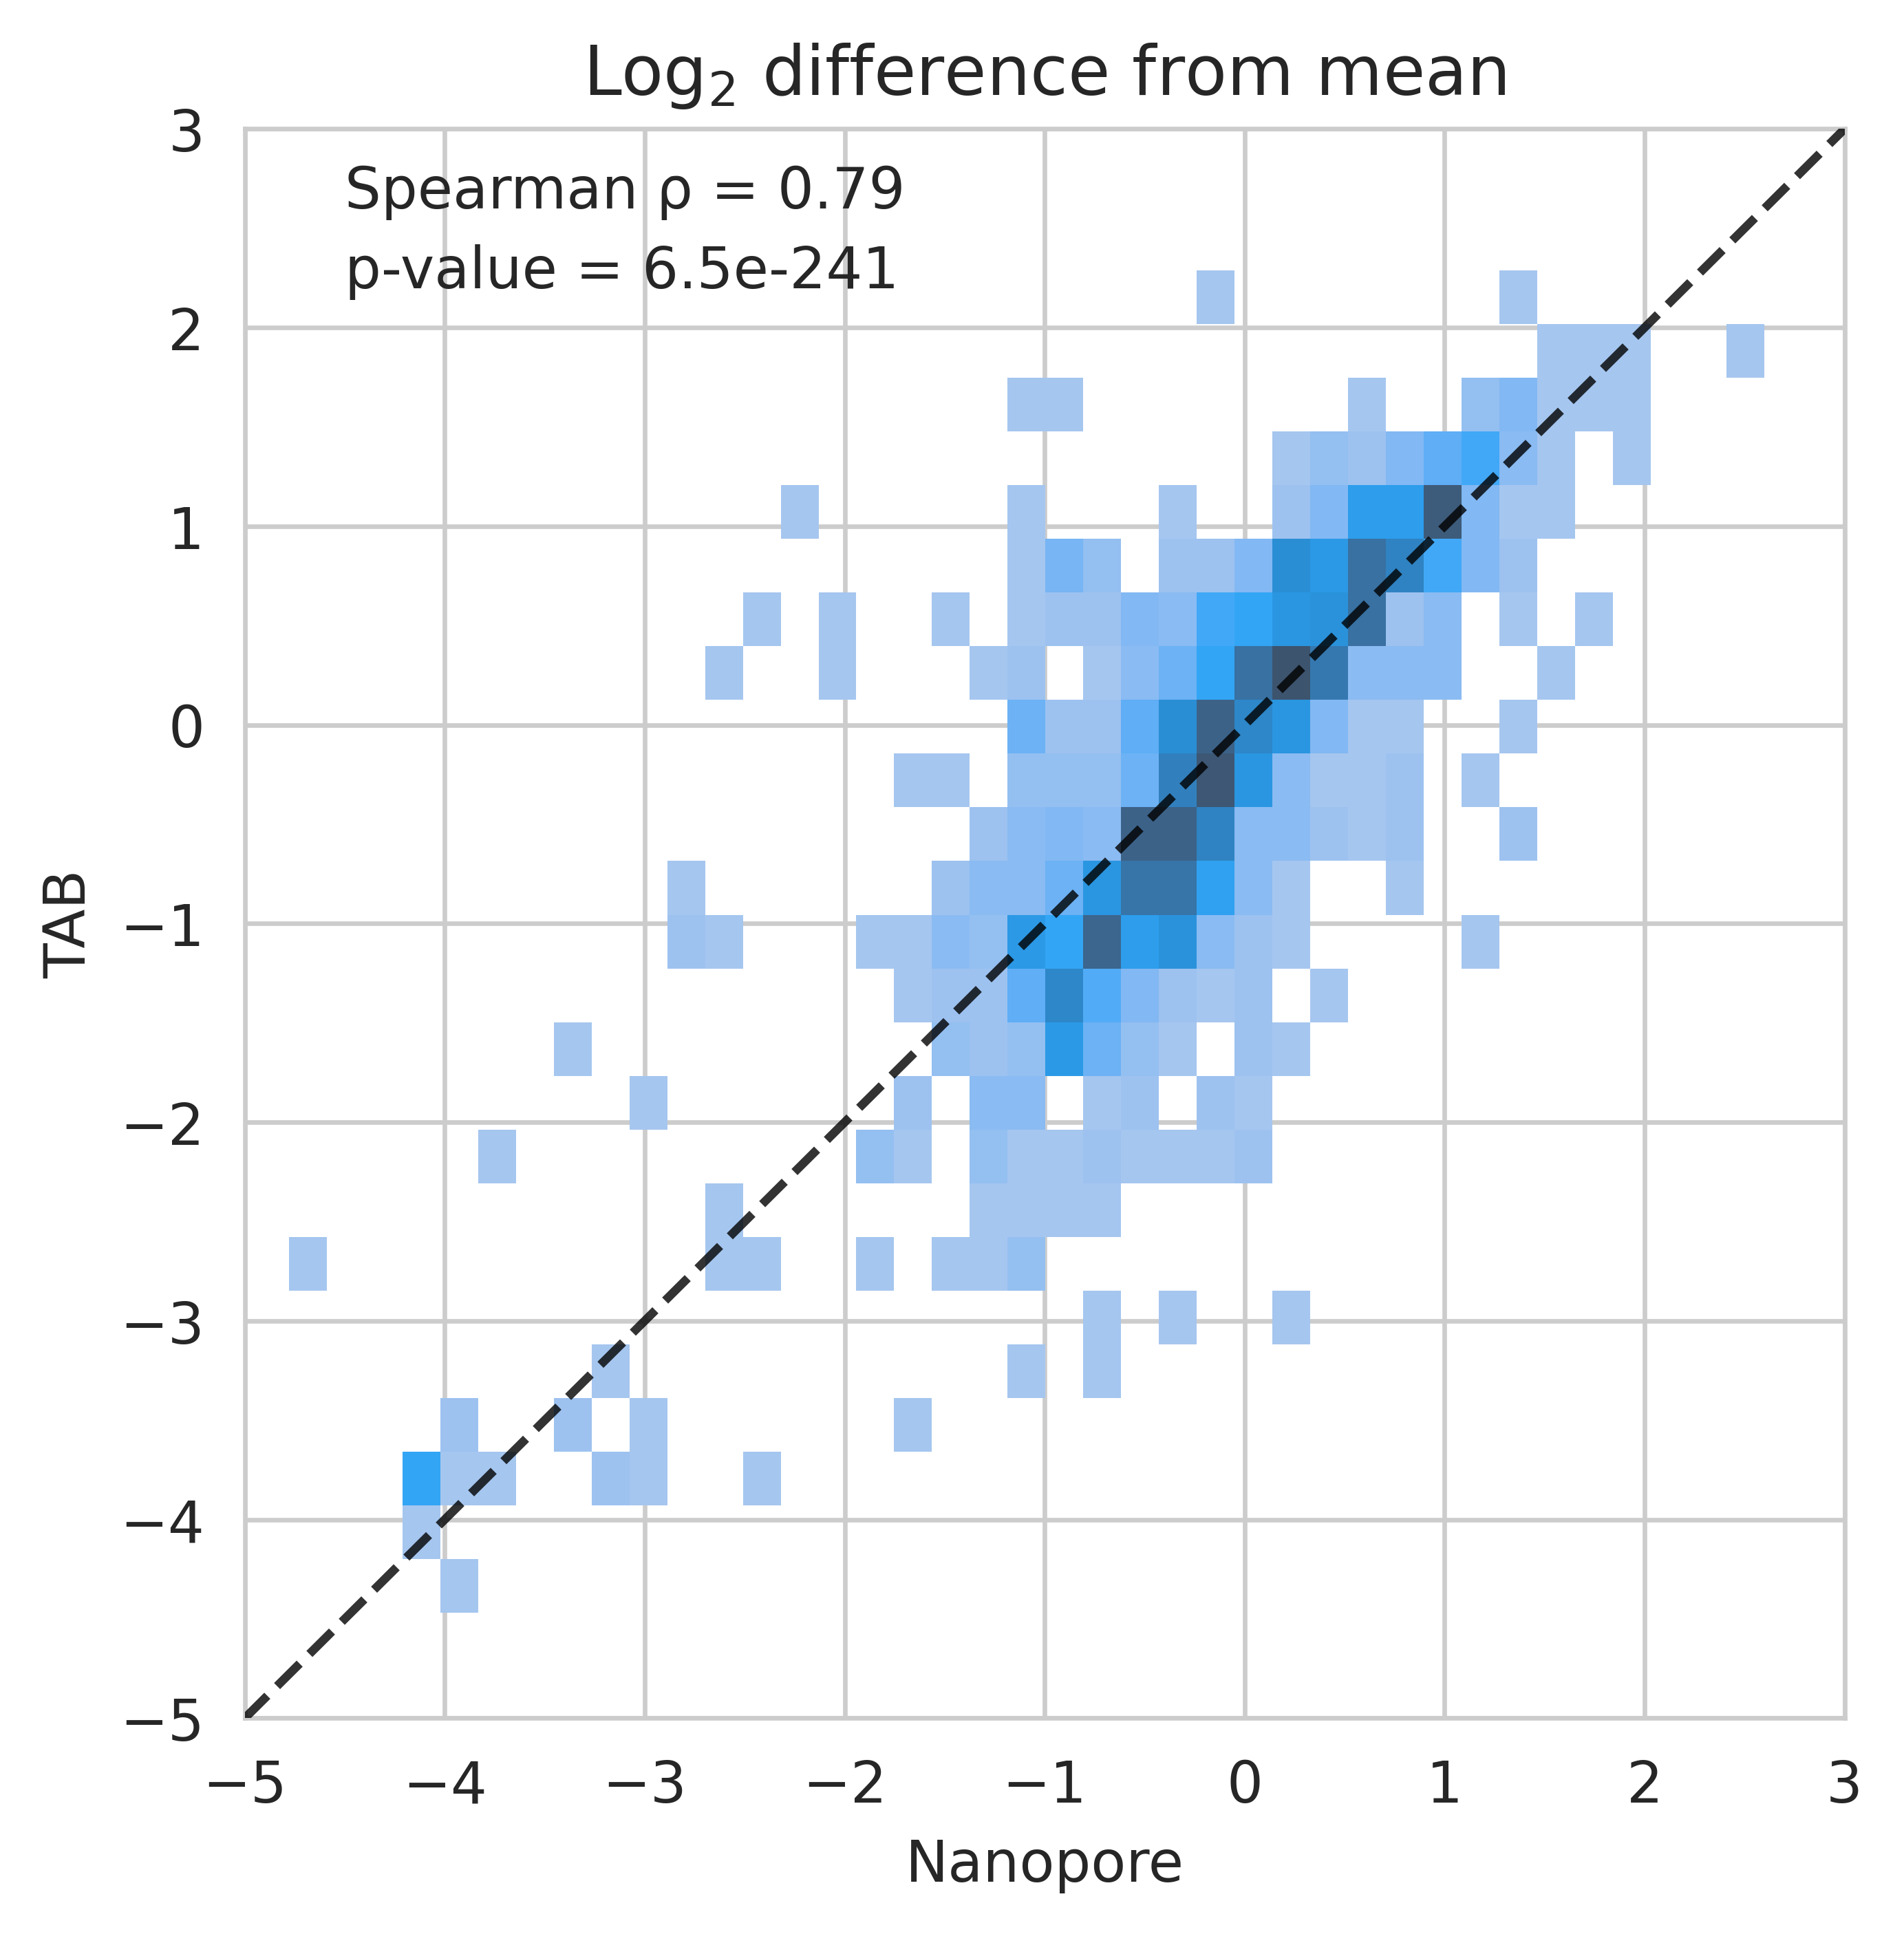

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_style("whitegrid")

fig = plt.figure(dpi=600, figsize=(5, 5))

ax1 = fig.add_subplot()

sns.histplot(ax1Main().dropna(), x= "log2FromMean_Nanopore", y="log2FromMean_TAB", ax=ax1)
ax1.set_xlim(-5, 3)
ax1.set_ylim(-5, 3)
ax1.plot(np.arange(-5, 4, 1), np.arange(-5, 4, 1), linestyle="dashed", color="black", zorder=5, alpha=0.8)
ax1.set_title("Log$_{2}$ difference from mean")
ax1.set_xlabel("Nanopore")
ax1.set_ylabel("TAB")

rho = stats.spearmanr(ax1Main().dropna()["log2FromMean_Nanopore"], 
                      ax1Main().dropna()["log2FromMean_TAB"])

ax1.text(-4.5, 2.6, "Spearman \u03C1 = {rho:.2f}".format(rho=rho[0]))
ax1.text(-4.5, 2.2, "p-value = {rho:.1e}".format(rho=rho[1]))

fig.show()
